In [4]:
import pickle
pathFolder = "./wine_quality/"
xTrainName = "xTrain1.pkl"
yTrainName = "yTrain.pkl"
with open(pathFolder+xTrainName,'rb') as f1:
    X = pickle.load(f1)
with open(pathFolder+yTrainName,'rb') as f2:
    Y = pickle.load(f2)

In [5]:
type(X), type(Y)

(numpy.ndarray, numpy.ndarray)

In [10]:
X_np = X.to_numpy()
Y_np = Y.to_numpy()

In [8]:
type(X_np)

numpy.ndarray

In [9]:
X_np.shape

(1599, 11)

In [11]:
import numpy as np

# 데이터를 2차원 배열로 변환하기 위한 모양 결정
# 예: 각 샘플을 4x3 형태로 변환 (가장 가까운 직사각형 형태)
# 이는 각 특성을 2D 배열에 배치하는 간단한 방법을 보여줌

# 샘플을 11x1 형태의 2D 배열로 변환
X_2d = np.reshape(X, (1599, 11, 1))

X_2d.shape



(1599, 11, 1)

In [8]:
from sklearn.model_selection import train_test_split

# 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((1279, 11), (320, 11), (1279,), (320,))

1단계: 필요한 라이브러리 임포트

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset,random_split


In [9]:
# 데이터를 PyTorch 텐서로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# TensorDataset 객체 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoader 생성
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


3단계: CNN 모델 정의

In [41]:
#Accuracy: 76.5625%
class WineCNN(nn.Module):
    def __init__(self):
        super(WineCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=11, out_channels=64, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=1)
        self.pool = nn.MaxPool1d(kernel_size=1)
        self.fc1 = nn.Linear(128, 64)
        self.dropout1 = nn.Dropout(0.5)#드롭아웃을 추가하여 과적합 방지 실제로 손실이 줄었음
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(32, 2)  # 2개의 출력 클래스 (품질: 좋음/나쁨)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)  # 배치 차원을 제외하고 평탄화
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
#연구 노트
#드롭아웃 있을때랑 없을때랑 그래프 비교하기

In [26]:
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

class betterWineCNN(nn.Module):
    def __init__(self):
        super(WineCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=11, out_channels=64, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(num_features=64)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=1)
        self.bn2 = nn.BatchNorm1d(num_features=128)
        self.pool = nn.MaxPool1d(kernel_size=1)
        self.fc1 = nn.Linear(128, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

#model = betterWineCNN()
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
#scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


In [42]:
#4단계: 모델, 손실 함수, 옵티마이저 설정
from torch.utils.data.dataset import random_split
import torch.optim as optim
# 모델 인스턴스 생성
model = betterWineCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
# 훈련 세트를 훈련 및 검증 세트로 분할
num_train = len(train_dataset)
num_val = int(0.2 * num_train)
train_ds, val_ds = random_split(train_dataset, [num_train - num_val, num_val])

# DataLoader 업데이트
train_loader = DataLoader(dataset=train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_ds, batch_size=16, shuffle=False)

# 최적의 모델을 저장하기 위한 초기 설정
best_val_loss = float('inf')
best_model = None
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# 학습 과정
epochs = 50
for epoch in range(epochs):
    train_loss, train_correct = 0, 0
    val_loss, val_correct = 0, 0
    total = 0
    
    # 훈련 부분
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(output, 1)
        train_correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)
    
    train_acc = 100 * train_correct / total
    
    # 검증 부분
    model.eval()
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(output, 1)
            val_correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    
    val_acc = 100 * val_correct / total
    
    # 이력 저장
    history['train_loss'].append(train_loss / len(train_loader))
    history['val_loss'].append(val_loss / len(val_loader))
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    # 최적의 모델 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()
        
    print(f'Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader)}, Train Acc: {train_acc}%, '
          f'Val Loss: {val_loss / len(val_loader)}, Val Acc: {val_acc}%')
    
# 최적의 모델을 파일로 저장
#torch.save(best_model, 'best_model.pth')


Epoch 1, Train Loss: 0.6721921022981405, Train Acc: 57.32421875%, Val Loss: 0.609078548848629, Val Acc: 69.41176470588235%
Epoch 2, Train Loss: 0.5582488910295069, Train Acc: 72.8515625%, Val Loss: 0.539694806560874, Val Acc: 72.94117647058823%
Epoch 3, Train Loss: 0.5310600670054555, Train Acc: 73.6328125%, Val Loss: 0.5246050469577312, Val Acc: 74.50980392156863%
Epoch 4, Train Loss: 0.5312347351573408, Train Acc: 73.828125%, Val Loss: 0.5373351518064737, Val Acc: 72.94117647058823%
Epoch 5, Train Loss: 0.5344622544944286, Train Acc: 74.21875%, Val Loss: 0.520468108355999, Val Acc: 73.72549019607843%
Epoch 6, Train Loss: 0.53781728586182, Train Acc: 72.75390625%, Val Loss: 0.5493992194533348, Val Acc: 72.15686274509804%
Epoch 7, Train Loss: 0.5252858716994524, Train Acc: 75.0%, Val Loss: 0.5168340113013983, Val Acc: 73.72549019607843%
Epoch 8, Train Loss: 0.522375809494406, Train Acc: 74.8046875%, Val Loss: 0.5310322567820549, Val Acc: 74.90196078431373%
Epoch 9, Train Loss: 0.518335

In [43]:
#6단계: 모델 평가
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        _, predicted = torch.max(output.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f'Accuracy: {100 * correct / total}%')


Accuracy: 76.5625%


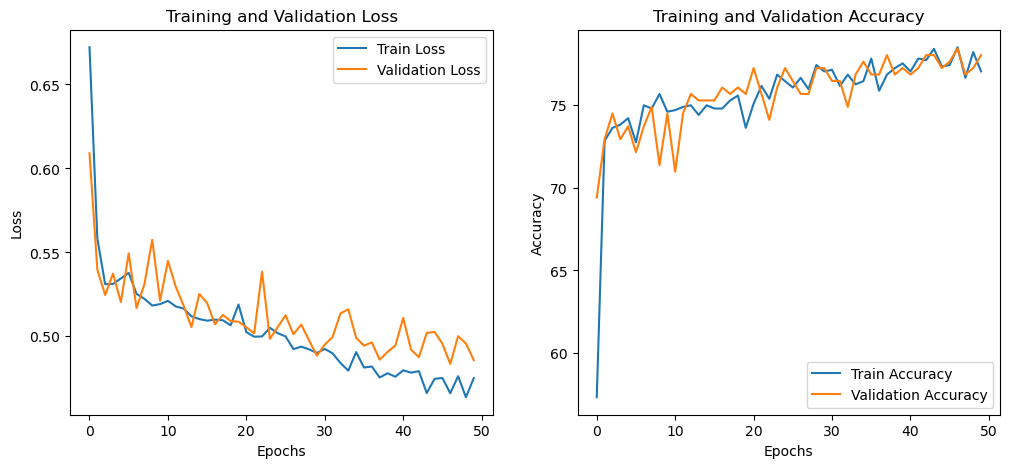

In [44]:
import matplotlib.pyplot as plt

# history 딕셔너리에 저장된 훈련 및 검증 손실과 정확도 값을 가져옵니다.
train_loss = history['train_loss']
val_loss = history['val_loss']
train_acc = history['train_acc']
val_acc = history['val_acc']

# 손실 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
